# <center><h1> TP 2 : Régression Linéaire </center></h1>

In [1]:
# Imports
import pandas as pd
import numpy as np
from random import randrange
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import KFold
import warnings 

In [2]:
# Constante
FILE = 'data_contamine.csv'
NBR_COLUMNS = 160
NBR_ROWS = 442

# Configuration
warnings.filterwarnings('ignore')

## Question 1

Chargement est vérification du nombre de variables explicatives et le nombres d'observations

In [3]:
def read_data(file):
    df = pd.DataFrame()
    return pd.read_csv(file, sep=',', names=["X" + str(x) if x != NBR_COLUMNS+1 else "Y" for x in range(1, NBR_COLUMNS+2)])

In [4]:
# Data read
data = read_data(FILE)
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X152,X153,X154,X155,X156,X157,X158,X159,X160,Y
0,0.223773,2.407005,-0.536073,-1.336626,-0.097947,1.549540,1.590890,1.190101,-1.181936,2.731036,...,-1.157572,-0.316955,-1.041194,-0.929746,-1.779339,-1.429081,2.685259,0.953334,-0.564672,151.0
1,-0.515789,-0.799958,1.582195,-0.008126,0.414271,1.363709,-0.098582,-0.302917,-0.544602,-0.241896,...,0.241794,-0.937335,0.288955,-0.177624,0.084456,0.633965,1.052004,-0.113860,0.505908,75.0
2,0.023454,0.048646,0.224159,0.655717,-0.176065,1.605403,1.638630,-1.240650,2.100396,-1.031570,...,0.483655,0.869513,0.881769,-0.958674,1.880679,0.608850,-0.057137,-0.950829,-0.594289,141.0
3,0.892292,-0.494714,-1.062153,0.736429,-0.118200,-1.078412,-0.454316,-0.378080,2.679422,-0.051751,...,0.385350,-0.021720,0.863478,0.256292,0.293780,0.216499,-0.637889,-1.179666,-1.112571,206.0
4,-1.021634,-1.805761,0.082164,0.387965,-0.838219,1.596253,0.037945,-1.012175,1.632963,-0.533814,...,0.661239,0.329027,-0.757433,0.082726,0.267892,0.282614,-2.022049,-2.201643,0.786962,135.0


In [5]:
# Extraction of X and  y (dataFrame)
df_X = data[data.columns[:-1]].copy()
df_Y = data[data.columns[-1:]].copy()

# Extraction of X and  y (np array())
np_data = np.array(data)
np_X = np_data[:,:-1]
np_Y = np_data[:,-1]

In [6]:
X_rows, X_columns = np_X.shape
print(f'Nombre de variables explicatives {X_columns} \n\
Nombre de variables à expliquer {np_data.shape[1] - X_columns} \n\
Nombres d\'observations {X_rows}')

Nombre de variables explicatives 160 
Nombre de variables à expliquer 1 
Nombres d'observations 442


## Question 2
Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à expliquer ?

In [7]:
is_X_centree = np.allclose(np_X.mean(axis=0), 0)
is_X_reduite = np.allclose(np_X.std(axis=0), 1)

is_Y_centree = np.allclose(np_Y.mean(axis=0), 0)
is_Y_reduite = np.allclose(np_Y.std(axis=0), 1)
print(f'X : Les variables explicatives sont-elles centrées ? {is_X_centree}\n\
X : Les variables explicatives sont-elles Normalisées ? {is_X_reduite}')

print(f'Y : La variable à expliquer est-elle centrée ? {is_Y_centree}\n\
Y : La variable à expliquer est-elle Normalisée ? {is_Y_reduite}\n\
Y : Espérance des variables  {np_Y.mean(axis=0)} \n\
Y : Ecart type des variables  {np_Y.std(axis=0)}')

print()
print('D\'après l\'étude effectuée, il apparait que les variables explicatives (X) sont centrées et réduites, ce qui n\'est pas le cas pour la variable à expliquer (Y)')

X : Les variables explicatives sont-elles centrées ? True
X : Les variables explicatives sont-elles Normalisées ? True
Y : La variable à expliquer est-elle centrée ? False
Y : La variable à expliquer est-elle Normalisée ? False
Y : Espérance des variables  152.13348416289594 
Y : Ecart type des variables  77.00574586945044

D'après l'étude effectuée, il apparait que les variables explicatives (X) sont centrées et réduites, ce qui n'est pas le cas pour la variable à expliquer (Y)


#
Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à
expliquer (un scatterplot regroupe les graphes de chacune des variables en fonction de chacune des
autres). Commenter les graphiques obtenus.

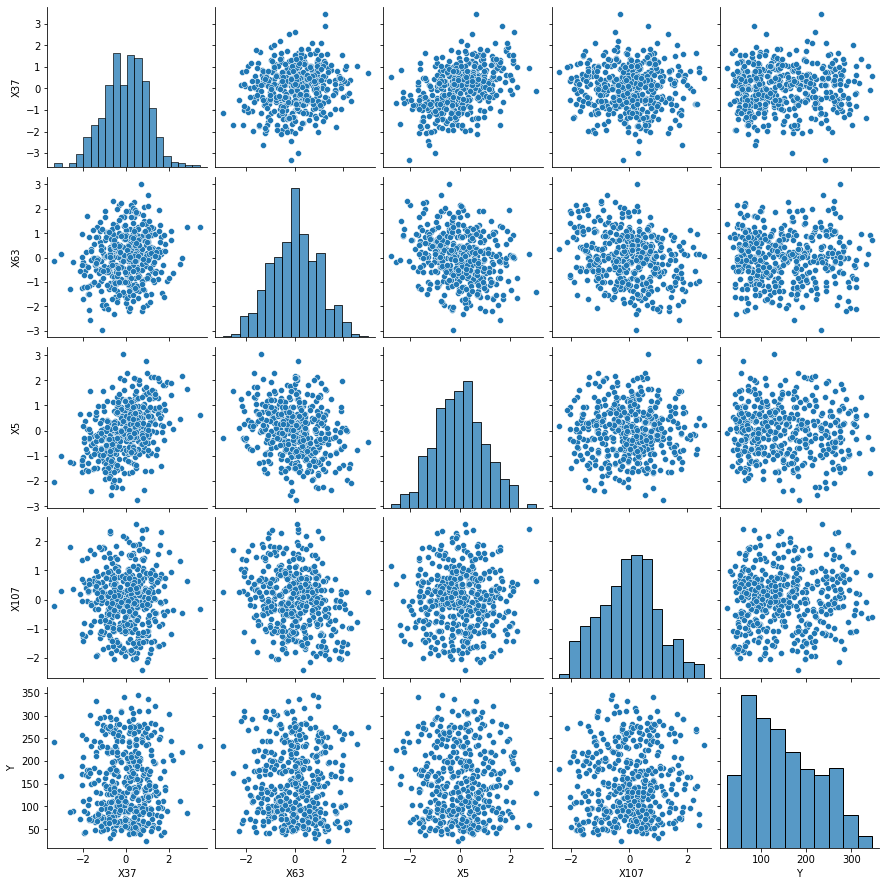

In [8]:
# Get columns name
columns_name = []
for index in range(4):
    columns_name.append('X'+str(randrange(1, 160)))

scatter_data = df_X[columns_name].copy()
scatter_data['Y'] = df_Y.copy()
sns.pairplot(scatter_data);

## Question 3
Echantillon d’apprentissage et de test. Créer 2 échantillons : un pour apprendre le modèle Xtrain,
un pour tester le modèle Xtest. On mettra 25% de la base dans l’échantillon ’test’. Donner les tailles
de chacun des 2 échantillons. On notera que le nouvel échantillon de covariables Xtrain n’est pas
normalisé. Dans la suite, on fera donc bien attention à inclure l’intercept dans nos régressions.

In [9]:
# Get columns name ()
columns_name = []
range_train = int(np.floor(len(df_X)*3/4))
for index in range(range_train):
    columns_name.append('X'+str(randrange(1, 160)))

scatter_data = df_X[columns_name].copy()

In [10]:
df_X_train, df_X_test, df_Y_train, df_Y_test = model_selection.train_test_split(df_X, df_Y, test_size=0.25)
print(f'La taille du X train est {df_X_train.shape} \n\
La taille du X test est {df_X_test.shape}')

La taille du X train est (331, 160) 
La taille du X test est (111, 160)


## Question 4

Donner la matrice de covariance calculée sur Xtrain. Tracer le graphe de la décroissance des valeurs
propres de la matrice de covariance (ou de corrélation). Expliquer pourquoi il est légitime de ne
garder que les premières variables de l’ACP. On gardera 20 variables dans la suite.

In [11]:
X_cov_matrix = df_X_train.cov()
X_cov_matrix

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160
X1,0.968774,0.264322,-0.010896,0.272416,0.086431,-0.091510,0.084994,0.252101,-0.097797,-0.092154,...,-0.049376,0.099117,0.200319,0.109598,-0.022840,0.153906,0.309748,-0.141221,0.026384,-0.126211
X2,0.264322,1.028215,0.181699,-0.239486,0.032646,0.201614,0.218272,-0.012212,-0.198095,0.039471,...,-0.113614,0.126653,0.129472,-0.029639,0.045002,0.089968,0.164642,0.185205,0.168017,-0.214250
X3,-0.010896,0.181699,1.003586,-0.128141,0.256772,0.340147,-0.277351,0.021300,-0.171298,-0.317931,...,0.061626,-0.219435,-0.048513,0.364248,0.034249,0.084868,0.162177,0.232649,-0.078541,0.321363
X4,0.272416,-0.239486,-0.128141,0.990361,0.150404,-0.291264,0.068412,0.495014,0.064231,-0.155832,...,-0.264503,-0.282477,0.200804,-0.235835,0.022500,0.329844,0.104082,0.124228,-0.119075,0.050882
X5,0.086431,0.032646,0.256772,0.150404,1.012204,-0.275163,-0.121179,-0.336811,-0.401962,-0.056234,...,-0.013601,-0.218255,0.365687,0.100710,-0.033105,0.106240,-0.052311,0.028904,0.088827,0.234748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X156,0.153906,0.089968,0.084868,0.329844,0.106240,-0.122931,0.219308,0.087574,0.213965,-0.233817,...,-0.072576,0.048613,0.197333,0.462443,0.053849,0.985892,0.004290,0.026278,-0.036104,-0.189981
X157,0.309748,0.164642,0.162177,0.104082,-0.052311,-0.093607,-0.035232,0.023464,0.128615,-0.181771,...,0.099639,-0.278682,-0.108068,0.009897,-0.030811,0.004290,0.999935,0.056916,-0.011057,-0.109420
X158,-0.141221,0.185205,0.232649,0.124228,0.028904,0.066124,0.189348,0.263954,-0.172247,0.150302,...,-0.578998,-0.331571,-0.145372,-0.013727,0.026197,0.026278,0.056916,1.004028,0.041478,-0.026466
X159,0.026384,0.168017,-0.078541,-0.119075,0.088827,-0.085621,0.141870,0.303102,-0.532349,0.084630,...,0.135386,-0.050507,-0.251035,0.197326,-0.063939,-0.036104,-0.011057,0.041478,1.027551,0.009058


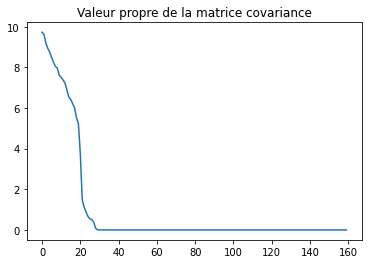

In [12]:
eigenvalues, eigenvector = np.linalg.eigh(X_cov_matrix)
eigenvalues = np.flip(np.sort(eigenvalues, axis=None))
plt.plot(eigenvalues)
plt.title('Valeur propre de la matrice covariance')
plt.show()

In [13]:
# Extract of 20 data for X_train and X_test
u_array, s_arry, vh_array = np.linalg.svd(X_cov_matrix, full_matrices = True)
X_train_20 =  np.dot(df_X_train, u_array[:, :20])
X_test_20 =  np.dot(df_X_test, u_array[:, :20])
x_abscissa = np.linspace(1, 20, 20)

On remarque qu'apeu près les 27 premières valeurs sont différentes de 0.

## Question 5
Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS" qui
consiste à appliquer OLS avec Y et XtrainVp1:20q, où Vp1:20qcontient les vecteurs propres (associés
aux 20 plus grandes valeurs propres) de la matrice de covariance. Faire une régression linéaire (avec
intercept), puis tracer les valeurs des coefficients (hors intercept). Sur un autre graphique, faire de
même avec la méthode des moindres carrés classique.Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS" qui
consiste à appliquer OLS avec Y et XtrainVp1:20q, où Vp1:20qcontient les vecteurs propres (associés
aux 20 plus grandes valeurs propres) de la matrice de covariance. Faire une régression linéaire (avec
intercept), puis tracer les valeurs des coefficients (hors intercept). Sur un autre graphique, faire de
même avec la méthode des moindres carrés classique.

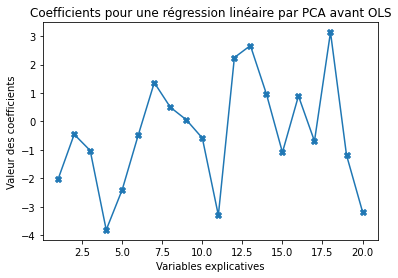

In [14]:
# Calculate of PCA and OLS
lin_reg_pca_ols = LinearRegression(fit_intercept=True).fit(X_train_20, df_Y_train)

plt.scatter(x_abscissa, lin_reg_pca_ols.coef_, marker='X')
plt.plot(x_abscissa, lin_reg_pca_ols.coef_[0])
plt.title('Coefficients pour une régression linéaire par PCA avant OLS')
plt.xlabel('Variables explicatives')
plt.ylabel('Valeur des coefficients')
plt.show();


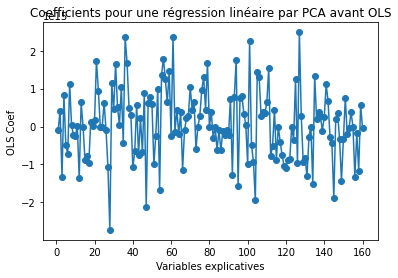

In [15]:
lin_reg_ols = LinearRegression(fit_intercept=True).fit(df_X_train, df_Y_train)

plt.scatter(np.linspace(1, 160, 160), lin_reg_ols.coef_)
plt.plot(np.linspace(1, 160, 160), lin_reg_ols.coef_[0])
plt.title('Coefficients pour une régression linéaire par PCA avant OLS')
plt.xlabel('Variables explicatives')
plt.ylabel('OLS Coef')
plt.show();

## Question 6
Donner les valeurs des intercepts pour les 2 régressions précédentes. Donner la valeur moyenne
de la variable Y (sur le train set). Les intercepts des 2 questions sont-ils égaux ? Commenter.
Uniquement pour cette question, centrer et réduire les variables après ACP (de petite dimension).
Faire une régression avec ces variables et vérifier que l’intercept est bien égal à la moyenne de Y
sur le train.

In [16]:
# Intercept value 
print(f'La valeur de l\'intercept pour OLS {lin_reg_ols.intercept_[0]}')
print(f'La valeur de l\'intercept pour PCA before OLS {lin_reg_pca_ols.intercept_[0]}')
print(f'La valeur moyanne de la variable Y sur le train set est {np.mean(df_Y_train.to_numpy())}')
print(f'Les intercepts des 2 questions sont-ils égaux ? {np.isclose(lin_reg_ols.intercept_[0], lin_reg_pca_ols.intercept_[0])}')

La valeur de l'intercept pour OLS 154.01680513595167
La valeur de l'intercept pour PCA before OLS 154.0865087395836
La valeur moyanne de la variable Y sur le train set est 153.32930513595167
Les intercepts des 2 questions sont-ils égaux ? False


On remarques l'inégalités des deux intercepts, ce qui peux être expliqué par le fait qu les valeurs de X ne sont pas centrées et réduites. La partie suivante nous permettra de valider ou non cette hypothèse.

In [17]:
X_train_20_new = scale(X_train_20)
lin_reg = LinearRegression(fit_intercept=True).fit(X_train_20_new, df_Y_train)

print(f'L’intercept après PCA est-il bien égal à la moyenne de Y sur le train ? {np.isclose(lin_reg.intercept_[0], np.mean(df_Y_train.to_numpy()))}')

L’intercept après PCA est-il bien égal à la moyenne de Y sur le train ? True


On remarque que les deux resultats sont égaux (intercept et moyenne)

## Question 7
Pour les 2 méthodes (OLS et PCA before OLS) : Tracer les résidus de la prédiction sur
l’échantillon test. Tracer leur densité (on pourra par exemple utiliser un histogramme).
Calculer le coefficient de détermination sur l’échantillon test. Calculer le risque de prédiction
sur l’échantillon test.

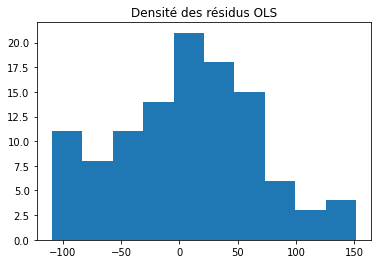

In [18]:
# OLS
residue_ols = lin_reg_ols.predict(df_X_test) - df_Y_test
plt.hist(residue_ols)
plt.title('Densité des résidus OLS');

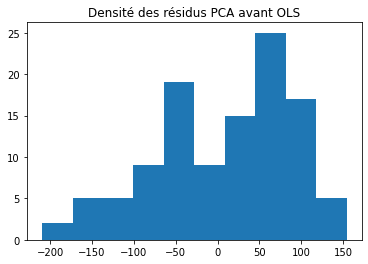

In [19]:
# PCA before OLS
residue_pca_ols = lin_reg_pca_ols.predict(X_test_20) - df_Y_test
plt.hist(residue_pca_ols)
plt.title('Densité des résidus PCA avant OLS');

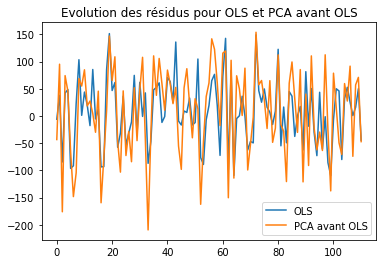

In [20]:
plt.figure()
plt.plot(np.sort(residue_ols), label="OLS")
plt.plot(np.sort(residue_pca_ols), label="PCA avant OLS")
plt.legend()
plt.title("Evolution des résidus pour OLS et PCA avant OLS")
plt.show()

In [21]:
# R coef
print(f'Le coefficient de détermination (R2) de OLS {lin_reg_ols.score(df_X_test, df_Y_test)}')
print(f'Le coefficient de détermination (R2) de PCA  aavnt OLS {lin_reg_pca_ols.score(X_test_20, df_Y_test)}')

Le coefficient de détermination (R2) de OLS 0.4176399124893868
Le coefficient de détermination (R2) de PCA  aavnt OLS -0.052354838644759205


In [22]:
def calc_risk(residue):
    risk = 0
    for res in residue:
        risk += res**2
    return (risk / len(residue))[0]
risk_ols = calc_risk(residue_ols.to_numpy())
risk_pca_ols = calc_risk(residue_pca_ols.to_numpy())
print(f'Le risque de prédiction OLS pour l\'échantillon de test {risk_ols}')
print(f'Le risque de prédiction PCA avant OLS pour l\'échantillon de test {risk_pca_ols}')

Le risque de prédiction OLS pour l'échantillon de test 3605.392577950788
Le risque de prédiction PCA avant OLS pour l'échantillon de test 6515.131112159652


## Question 8
Coder la méthode de Forward variable sélection. On pourra utiliser la statistique du test de nullité
du coefficient (comme vu en cours). Pour l’instant, on ne met pas de critère d’arrêt sur la méthode,
c’est-à-dire que l’on ajoute une variable à chaque étape jusqu’à retrouver la totalité des variables.
Sachant que le jeu de données initiales ne contenait que les variables [22, 82, 23, 132, 154, 79, 115,
73, 122, 13], combien Forward en a-t-il retrouvé ?

In [23]:
var_list = [22, 82, 23, 132, 154, 79, 115, 73, 122, 13]

def tstat(coeff, residus, Xk):
    sigma2_chapeau = ((np.linalg.norm(residus))**2)/(len(Xk) - 1)
    tstat = coeff / np.sqrt((sigma2_chapeau**(1/2) / np.dot(Xk.T, Xk)))
    return tstat

def forward_varariable(X, Y, nbr_var):
    var_forward = []
    index_forward = []
    _Y = Y.copy()
    X_stand = scale(X)
    while(len(var_forward) < nbr_var):
        max_tstat = 0
        i = 0
        for X_i in X_stand.T:
            if i in index_forward:
                i += 1
                continue
            _Y_stand = scale(_Y)
            lin_reg_forward = LinearRegression(fit_intercept=False)
            pca_forward = lin_reg_forward.fit(X_i.reshape(-1, 1) , _Y)
            residus = _Y - pca_forward.predict(X_i.reshape(-1, 1))
            t_stat = tstat(abs(pca_forward.coef_[0]), residus, X_i)
            if(t_stat>max_tstat):
                max_tstat = t_stat
                next_forward = X_i
                _Y = residus
                index = i
            i += 1
        var_forward.append(next_forward)
        index_forward.append(index)
    var_forward = np.array(var_forward).T
    return index_forward

var_found = forward_varariable(df_X_train, df_Y_train, len(var_list))
common_var = list(set(var_list).intersection(var_found))
print(f'Jeu initial des variables : {var_list}')
print(f'Jeu de variables retrouvés avec la méthode du foward variable : {var_found}')
print(f'Le foward a trouvé {len(common_var)}/{len(var_list)}, la liste des variables est : {common_var}')

Jeu initial des variables : [22, 82, 23, 132, 154, 79, 115, 73, 122, 13]
Jeu de variables retrouvés avec la méthode du foward variable : [23, 122, 13, 132, 82, 115, 45, 142, 154, 79]
Le foward a trouvé 8/10, la liste des variables est : [132, 154, 13, 79, 82, 115, 23, 122]


## Question 9
Appliquer OLS sur les variables sélectionnées. Donner le risque de prédiction obtenu sur l’échantillon
test et le comparer à ceux de OLS et PCA before OLS. 

In [24]:
X_train_for_ols = df_X_train.to_numpy()[:,var_found]
X_test_for_ols = df_X_test.to_numpy()[:,var_found]

lin_reg_ols_2 = LinearRegression(fit_intercept=True).fit(X_train_for_ols, df_Y_train)
residue_ols_2 = lin_reg_ols_2.predict(X_train_for_ols) - df_Y_train
risk_ols_2 = calc_risk(residue_ols_2.to_numpy())
print(f'Le risque de prédiction obtenu sur l’échantillon test est {risk_ols_2}')

print(f'riks_ols = {risk_ols} \n\
risk_pca_ols = {risk_pca_ols} \n\
risk_ols_foward = {risk_ols_2}\n\
On remarque que le risque de prédiciton obtenu sur l\'échantillon de test est le plus petit, donc une amélioration de la précision de la prédiction')

Le risque de prédiction obtenu sur l’échantillon test est 2720.761891695884
riks_ols = 3605.392577950788 
risk_pca_ols = 6515.131112159652 
risk_ols_foward = 2720.761891695884
On remarque que le risque de prédiciton obtenu sur l'échantillon de test est le plus petit, donc une amélioration de la précision de la prédiction


## Question 10
Afin de préparer la validation croisée, séparer l’échantillon train en 5 parties (appelées ”folds”) de
façon aléatoire. On affichera les numéros d’échantillon sélectionnés dans chaque fold.

In [25]:
folds = KFold(n_splits=5, shuffle=True)

fold_X_train, fold_Y_train, fold_X_test, fold_Y_test = [], [], [], []

for train_id, test_id in folds.split(df_X_train):
    fold_X_train.append((df_X_train.iloc[train_id]))
    fold_X_test.append((df_X_train.iloc[test_id]))
    fold_Y_train.append((df_Y_train.iloc[train_id]))
    fold_Y_test.append((df_Y_train.iloc[test_id]))
    
# Fold for X_train
print('Fold for X train')
pd.DataFrame([fold.index for fold in fold_X_train], index=["Sample  1","Sample 2","Sample 3","Sample 4","Sample 5"])

Fold for X train


,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,264
Sample 1,406,426,309,191,241,400,116,144,261,7,...,283,432,14,286,367,358,260,302,192,NaN
Sample 2,406,190,309,241,81,397,281,149,168,144,...,25,283,432,388,14,286,58,367,358,260.0
Sample 3,190,426,309,191,400,81,397,116,281,149,...,283,388,14,286,58,367,358,260,302,192.0
Sample 4,406,190,426,191,241,400,81,397,116,281,...,284,216,25,189,432,388,58,358,302,192.0
Sample 5,406,190,426,309,191,241,400,81,397,116,...,283,432,388,14,286,58,367,260,302,192.0


## Question 11 
Appliquer la méthode de la régression Ridge. Pour le choix du paramètre de régularisation, on fera
une validation croisée sur les ”folds” définis lors de la question précédente. A tour de rôle chacun
des ”folds” servira à calculer le risque de prédiction alors que les autres seront utilisés pour estimer
le modèle. On moyennera ensuite les 5 risques de prédictions. On donnera la courbe du risque de
validation croisée en fonction du paramètre de régularisation (on veillera à bien choisir l’espace de
définition pour le graphe). Donner le paramètre de régularisation optimal et la valeur du risque sur
le test. 

## Question 12 
A l’aide de la fonction lassoCV de sklearn, choisir le paramètre de régularisation du LASSO. Donner
le risque de prédiction associé.

In [26]:
lasso = LassoCV().fit(df_X_train, df_Y_train)

print(f'Le paramètre de régulation du LASSO est {lasso.alpha_}')

Le paramètre de régulation du LASSO est 3.748626389243174


In [27]:
residue_lasso = lasso.predict(df_X_test) - df_Y_test.to_numpy()
risk_lasso = calc_risk(residue_lasso)
print(f'Le risque de prédiction obtenu avec le LASSO est {risk_lasso}')

Le risque de prédiction obtenu avec le LASSO est 10164.990109311882


In [28]:
print(f'riks_ols = {risk_ols} \n\
risk_pca_ols = {risk_pca_ols} \n\
risk_ols_foward = {risk_ols_2}\n\
risk_lasso = {risk_lasso}')

riks_ols = 3605.392577950788 
risk_pca_ols = 6515.131112159652 
risk_ols_foward = 2720.761891695884
risk_lasso = 10164.990109311882


## Question 13
Donner les variables selectionées par le Lasso. Combien y en a-t-il ? Appliquer la méthode OLS aux
variables sélectionnées. Cette méthode est appelé Least-Square LASSO.

## Question 14
Les variables initiales du jeu de données sont [22, 82, 23, 132, 154, 79, 115, 73, 122, 13]. Combien
le Lasso en a-t-il retrouvé ?